# STEP 1: DATA LOADING AND UNDERSTANDING

### important packages

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import balanced_accuracy_score,roc_auc_score, confusion_matrix, classification_report, accuracy_score


In [63]:
# READ DATA
train = pd.read_csv("train.csv")

In [64]:
train.head()

,id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude
0,1,fc7e6d61ad96136f2f84e65cb578719128a76777,2019-05-10T21:45:00Z,2019-05-10T22:00:00Z,420.0,0.00,8.0,8.0,6.00,0.00,0.0,0.0,6.00,Cash,Blue Ribbon Taxi Association Inc.,41.898332,-87.620763,41.907520,-87.626659
1,2,32e3320b2ad8fc0e4c90c95d962029be24d38ca2,2019-01-16T08:00:00Z,2019-01-16T08:00:00Z,419.0,1.00,8.0,8.0,6.25,1.00,0.0,0.0,7.75,Credit Card,City Service,41.892042,-87.631864,41.895033,-87.619711
2,3,39127d25654f081bbc273d7fe29e44c140d0c210,2018-10-27T14:30:00Z,2018-10-27T14:45:00Z,1175.0,3.30,33.0,8.0,13.25,3.31,NaN,0.0,16.56,Credit Card,Flash Cab,41.859350,-87.617358,41.892042,-87.631864
3,4,90bd7186d83d9653bd0453dd16c143941e597f6b,2019-09-25T17:30:00Z,2019-09-25T17:45:00Z,609.0,2.52,28.0,24.0,9.75,2.00,0.0,0.0,12.25,Credit Card,Sun Taxi,41.874005,-87.663518,41.901207,-87.676356
4,5,455653ef8a20a3125f30a4938ec1eedadef50ab5,2018-12-14T15:15:00Z,2018-12-14T15:30:00Z,1026.0,1.60,NaN,NaN,10.00,2.00,0.0,0.0,12.50,Credit Card,Flash Cab,NaN,NaN,NaN,NaN


In [65]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          200000 non-null  int64  
 1   taxi_id                     200000 non-null  object 
 2   trip_start_timestamp        200000 non-null  object 
 3   trip_end_timestamp          199989 non-null  object 
 4   trip_seconds                199950 non-null  float64
 5   trip_miles                  199989 non-null  float64
 6   pickup_community_area       185515 non-null  float64
 7   dropoff_community_area      180433 non-null  float64
 8   fare                        199980 non-null  float64
 9   tips                        199980 non-null  float64
 10  tolls                       189847 non-null  float64
 11  extras                      199980 non-null  float64
 12  trip_total                  199980 non-null  float64
 13  payment_type  

In [66]:
print(train.isnull().sum()/len(train) *100)

id                            0.0000
taxi_id                       0.0000
trip_start_timestamp          0.0000
trip_end_timestamp            0.0055
trip_seconds                  0.0250
trip_miles                    0.0055
pickup_community_area         7.2425
dropoff_community_area        9.7835
fare                          0.0100
tips                          0.0100
tolls                         5.0765
extras                        0.0100
trip_total                    0.0100
payment_type                  0.0000
company                       0.0000
pickup_centroid_latitude      7.2290
pickup_centroid_longitude     7.2290
dropoff_centroid_latitude     9.4375
dropoff_centroid_longitude    9.4375
dtype: float64


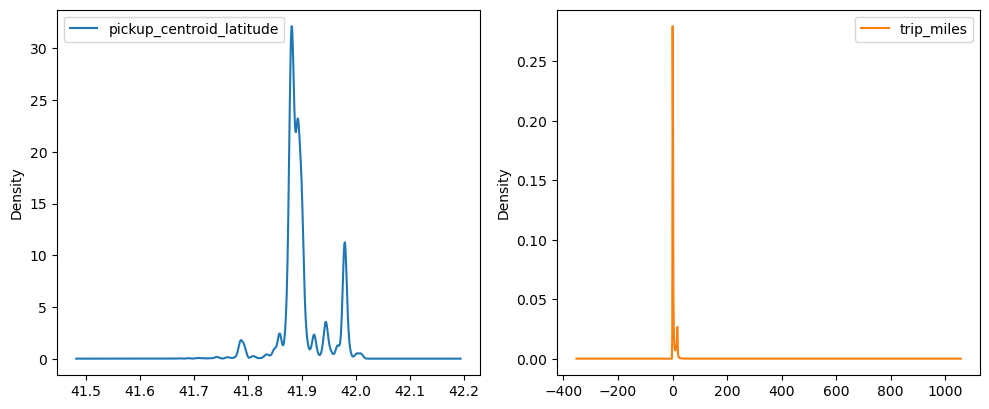

In [67]:
# Specify the columns to plot
columns_to_plot = ['payment_type', 'company', 'pickup_centroid_latitude','trip_miles']  # Replace with your column names

train[columns_to_plot].plot(kind='kde', subplots=True, layout=(2, 2), figsize=(10, 8), sharex=False)
plt.tight_layout()
plt.show()


In [68]:
columns_to_check = ['payment_type', 'company']  # Replace with your column names

for col in columns_to_check:
    if col in train.columns:
        print(f"Value percentages for column: {col}")
        value_counts = train[col].value_counts(normalize=True) * 100
        print(value_counts)
        print("\n")


Value percentages for column: payment_type
payment_type
Cash           49.5825
Credit Card    47.7605
Mobile          1.1625
Prcard          0.6975
Unknown         0.5370
No Charge       0.2095
Dispute         0.0360
Pcard           0.0080
Prepaid         0.0065
Name: proportion, dtype: float64


Value percentages for column: company
company
Taxi Affiliation Services                       19.8215
Flash Cab                                       14.5235
Chicago Carriage Cab Corp                       11.1860
Medallion Leasin                                 7.1660
Sun Taxi                                         7.1025
City Service                                     6.5670
Star North Management LLC                        5.8435
Blue Ribbon Taxi Association Inc.                4.7440
Choice Taxi Association                          3.3520
Taxi Affiliation Service Yellow                  3.2780
Globe Taxi                                       2.1370
Nova Taxi Affiliation Llc               

In [69]:
columns_to_display = ['id', 'is_working_day', 'trip_start_timestamp']

train[columns_to_display].head(20)

KeyError: "['is_working_day'] not in index"

# STEP 2: FEATURE ENGINEERING

In [70]:
public_holidays = [
    "2018-01-01", "2018-01-15", "2018-02-19", "2018-03-05", "2018-05-28",
    "2018-07-04", "2018-09-03", "2018-10-08", "2018-11-11", "2018-11-22",
    "2018-12-25", "2018-02-12", "2019-01-01", "2019-01-21", "2019-02-18",
    "2019-03-04", "2019-05-27", "2019-07-04", "2019-09-02", "2019-10-14",
    "2019-11-11", "2019-11-28", "2019-12-25", "2019-02-12"
]

train["trip_start_timestamp"] = pd.to_datetime(train['trip_start_timestamp'])

train["is_working_day"] = np.where(

    (train['trip_start_timestamp'].dt.weekday.isin(range(0,5))) &
    (train['trip_start_timestamp'].dt.strftime('%Y-%m-%d').isin(public_holidays) == False), 1, 0

)

train["is_rush_hour"] = np.where(
    (
        ((train['trip_start_timestamp'].dt.hour >= 7) & (train['trip_start_timestamp'].dt.hour < 9)) |
        ((train['trip_start_timestamp'].dt.hour == 9) & (train['trip_start_timestamp'].dt.minute == 0)) |
        ((train['trip_start_timestamp'].dt.hour >= 16) & (train['trip_start_timestamp'].dt.hour < 18)) |
        ((train['trip_start_timestamp'].dt.hour == 18) & (train['trip_start_timestamp'].dt.minute == 0))
    ) &
    (train['is_working_day'] == 1),
    1, 0
)

# fill na : extracts the first mode from the Series.
for col in ['trip_seconds', 'trip_miles']:
    train[col] = train[col].fillna(train[col].mode()[0])

train["mile/time"] = train["trip_miles"] / train["trip_seconds"]

# till this point there are still na value due to null division
global_mean = train['mile/time'][~train['mile/time'].isin([np.inf, -np.inf])].mean()
train['mile/time'] = train['mile/time'].replace([np.inf, -np.inf], np.nan).fillna(global_mean)


# more sophisticated way to get mode
def get_mode(series):
    return series.mode().iloc[0] if not series.mode().empty else np.nan



In [71]:
# Iterate over each column and fill missing values with mode grouped by taxi_id
for col in [
    'pickup_community_area', 'dropoff_community_area',
    'pickup_centroid_latitude', 'pickup_centroid_longitude',
    'dropoff_centroid_latitude', 'dropoff_centroid_longitude'
]:
    # Calculate mode for each taxi_id
    mode_by_taxi_id = train.groupby('taxi_id')[col].transform(get_mode)
    
    # Fill missing values in the column with the mode of the corresponding taxi_id group
    train[col] = train[col].fillna(mode_by_taxi_id)


### blackbox


In [72]:
# Drop unnecessary columns
train = train.drop(columns=[
    'taxi_id', 'trip_start_timestamp', 'trip_end_timestamp', 
    'payment_type', 'tolls', 'id','trip_total','company'
])

# Encode categorical columns
for col in train.select_dtypes('object').columns:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])

# Split data into training, validation, and test sets
X = train.drop(columns=['is_rush_hour'])
y = train['is_rush_hour']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123)

# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

# Train XGBoost model
xgb_model = xgb.train(
    {
        'max_depth': 5,
        'eta': 0.2,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'hist',
    },
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=500
)

# Predict on test set
y_pred = xgb_model.predict(dtest)
y_pred_binary = (y_pred >= 0.5).astype(int)


[0]	train-auc:0.74489	val-auc:0.74952
[1]	train-auc:0.75702	val-auc:0.76206
[2]	train-auc:0.75996	val-auc:0.76440
[3]	train-auc:0.76535	val-auc:0.77034
[4]	train-auc:0.76681	val-auc:0.77187
[5]	train-auc:0.76772	val-auc:0.77302
[6]	train-auc:0.76967	val-auc:0.77507
[7]	train-auc:0.77121	val-auc:0.77629
[8]	train-auc:0.77273	val-auc:0.77737
[9]	train-auc:0.77351	val-auc:0.77787
[10]	train-auc:0.77404	val-auc:0.77872
[11]	train-auc:0.77461	val-auc:0.77897
[12]	train-auc:0.77543	val-auc:0.77956
[13]	train-auc:0.77609	val-auc:0.78011
[14]	train-auc:0.77667	val-auc:0.78047
[15]	train-auc:0.77757	val-auc:0.78126
[16]	train-auc:0.77837	val-auc:0.78177
[17]	train-auc:0.77923	val-auc:0.78221
[18]	train-auc:0.77972	val-auc:0.78261
[19]	train-auc:0.78006	val-auc:0.78274
[20]	train-auc:0.78051	val-auc:0.78322
[21]	train-auc:0.78102	val-auc:0.78342
[22]	train-auc:0.78143	val-auc:0.78342
[23]	train-auc:0.78178	val-auc:0.78357
[24]	train-auc:0.78209	val-auc:0.78374
[25]	train-auc:0.78237	val-auc:0.78

In [76]:

# Confusion matrix and metrics
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# AUC Score
auc_score = roc_auc_score(y_test, y_pred)
print(f"AUC: {auc_score:.4f}")

# Predict probabilities on the test set
y_pred_prob_xgb = xgb_model.predict(dtest)

# Convert probabilities to binary predictions (threshold = 0.2)
y_pred_xgb = (y_pred_prob_xgb >= 0.25).astype(int)



# Compute confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:")
print(conf_matrix_xgb)

# Extract TN, FP, FN, TP
TN, FP, FN, TP = conf_matrix_xgb.ravel()


# Calculate recall for each class
recall_class_0 = TN / (TN + FP)  # Recall for class 0
recall_class_1 = TP / (TP + FN)  # Recall for class 1

# Calculate balanced accuracy
balanced_accuracy_xgb = (recall_class_0 + recall_class_1) / 2
print(f"Balanced Accuracy: {balanced_accuracy_xgb:.4f}")

from sklearn.metrics import balanced_accuracy_score

# Calculate balanced accuracy
balanced_accuracy_xgb = balanced_accuracy_score(y_test, y_pred_xgb)
print(f"Balanced Accuracy (Sklearn): {balanced_accuracy_xgb:.4f}")

Confusion Matrix:
[[23138   856]
 [ 5008   998]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.89     23994
           1       0.54      0.17      0.25      6006

    accuracy                           0.80     30000
   macro avg       0.68      0.57      0.57     30000
weighted avg       0.77      0.80      0.76     30000

AUC: 0.7795
Confusion Matrix:
[[17108  6886]
 [ 1962  4044]]
Balanced Accuracy: 0.6932
Balanced Accuracy (Sklearn): 0.6932
